# 🚀 Automated Product Data Extraction Pipeline
**Purpose:** Demonstrate automated ETL capabilities for product databases  

## Project Overview

This notebook demonstrates a production-ready data extraction pipeline that:
- Extracts data from multiple sources (APIs, databases, web sources)
- Implements robust error handling and logging
- Performs data validation and quality checks
- Transforms and standardizes product data
- Exports to multiple formats (CSV, JSON, Parquet, SQL)

### Relevance to Adobe
This pipeline architecture is applicable to:
- Adobe Commerce (Magento) product catalog management
- Adobe Experience Platform data ingestion
- Adobe Analytics product data pipelines
- Adobe Target experimentation data

---
## 1. Environment Setup & Dependencies

In [1]:
# Install required packages
!pip install pandas numpy requests sqlalchemy faker pyarrow openpyxl beautifulsoup4 aiohttp tqdm python-dateutil -q

print("✅ All dependencies installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.0 MB/s eta 0:00:00
✅ All dependencies installed successfully!


In [2]:
# Core imports
import pandas as pd
import numpy as np
import json
import requests
import sqlite3
import logging
import hashlib
import asyncio
import aiohttp
from datetime import datetime, timedelta
from typing import Dict, List, Optional, Any, Tuple
from dataclasses import dataclass, field, asdict
from abc import ABC, abstractmethod
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import wraps
import time
import os
import re
from io import StringIO
from tqdm import tqdm
from bs4 import BeautifulSoup
from faker import Faker
from sqlalchemy import create_engine, text
import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(levelname)-8s | %(name)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger('ProductExtractor')

print("✅ All modules imported successfully!")
print(f"📅 Execution Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All modules imported successfully!
📅 Execution Date: 2026-01-21 02:36:01


---
## 2. Configuration & Data Models

In [3]:
@dataclass
class ExtractionConfig:
    """Configuration for data extraction pipeline."""
    batch_size: int = 1000
    max_retries: int = 3
    retry_delay: float = 1.0
    timeout: int = 30
    max_workers: int = 5
    validate_data: bool = True
    log_level: str = "INFO"
    output_dir: str = "./extracted_data"

@dataclass
class Product:
    """Standardized product data model."""
    product_id: str
    sku: str
    name: str
    description: str
    category: str
    subcategory: str
    brand: str
    price: float
    currency: str = "USD"
    quantity_available: int = 0
    is_active: bool = True
    attributes: Dict[str, Any] = field(default_factory=dict)
    images: List[str] = field(default_factory=list)
    created_at: str = ""
    updated_at: str = ""
    source: str = ""
    extraction_timestamp: str = field(default_factory=lambda: datetime.now().isoformat())

    def to_dict(self) -> Dict:
        return asdict(self)

    def validate(self) -> Tuple[bool, List[str]]:
        """Validate product data integrity."""
        errors = []
        if not self.product_id:
            errors.append("Missing product_id")
        if not self.sku:
            errors.append("Missing SKU")
        if self.price < 0:
            errors.append(f"Invalid price: {self.price}")
        if self.quantity_available < 0:
            errors.append(f"Invalid quantity: {self.quantity_available}")
        return len(errors) == 0, errors

# Initialize configuration
config = ExtractionConfig()
os.makedirs(config.output_dir, exist_ok=True)

print("✅ Configuration loaded:")
print(f"   Batch Size: {config.batch_size}")
print(f"   Max Workers: {config.max_workers}")
print(f"   Output Directory: {config.output_dir}")

✅ Configuration loaded:
   Batch Size: 1000
   Max Workers: 5
   Output Directory: ./extracted_data


---
## 3. Utility Functions & Decorators

In [4]:
def retry_with_backoff(max_retries: int = 3, base_delay: float = 1.0):
    """Decorator for exponential backoff retry logic."""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            for attempt in range(max_retries):
                try:
                    return func(*args, **kwargs)
                except Exception as e:
                    if attempt == max_retries - 1:
                        logger.error(f"Failed after {max_retries} attempts: {e}")
                        raise
                    delay = base_delay * (2 ** attempt)
                    logger.warning(f"Attempt {attempt + 1} failed: {e}. Retrying in {delay}s...")
                    time.sleep(delay)
        return wrapper
    return decorator

def timer(func):
    """Decorator to measure execution time."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        elapsed = time.time() - start
        logger.info(f"{func.__name__} completed in {elapsed:.2f}s")
        return result
    return wrapper

def generate_hash(data: str) -> str:
    """Generate MD5 hash for data deduplication."""
    return hashlib.md5(data.encode()).hexdigest()

def clean_text(text: str) -> str:
    """Clean and normalize text data."""
    if not text:
        return ""
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text)     # Normalize whitespace
    return text.strip()

def parse_price(price_str: str) -> float:
    """Parse price string to float."""
    if isinstance(price_str, (int, float)):
        return float(price_str)
    try:
        cleaned = re.sub(r'[^\d.]', '', str(price_str))
        return float(cleaned) if cleaned else 0.0
    except ValueError:
        return 0.0

print("✅ Utility functions defined!")

✅ Utility functions defined!


---
## 4. Abstract Base Extractor Class

In [5]:
class BaseExtractor(ABC):
    """Abstract base class for all data extractors."""

    def __init__(self, config: ExtractionConfig):
        self.config = config
        self.logger = logging.getLogger(self.__class__.__name__)
        self.extraction_stats = {
            'total_records': 0,
            'successful': 0,
            'failed': 0,
            'duplicates': 0,
            'start_time': None,
            'end_time': None
        }

    @abstractmethod
    def connect(self) -> bool:
        """Establish connection to data source."""
        pass

    @abstractmethod
    def extract(self) -> List[Product]:
        """Extract products from data source."""
        pass

    @abstractmethod
    def transform(self, raw_data: Any) -> Product:
        """Transform raw data to standardized Product model."""
        pass

    def validate_products(self, products: List[Product]) -> List[Product]:
        """Validate and filter products."""
        valid_products = []
        for product in products:
            is_valid, errors = product.validate()
            if is_valid:
                valid_products.append(product)
                self.extraction_stats['successful'] += 1
            else:
                self.logger.warning(f"Invalid product {product.product_id}: {errors}")
                self.extraction_stats['failed'] += 1
        return valid_products

    def get_stats(self) -> Dict:
        """Return extraction statistics."""
        return self.extraction_stats

print("✅ Base Extractor class defined!")

✅ Base Extractor class defined!


---
## 5. Simulated Product Database (For Demo Purposes)

In [6]:
class ProductDatabaseSimulator:
    """Simulates a product database for demonstration."""

    def __init__(self, num_products: int = 5000):
        self.fake = Faker()
        self.num_products = num_products
        self.categories = {
            'Electronics': ['Smartphones', 'Laptops', 'Tablets', 'Accessories', 'Cameras'],
            'Software': ['Creative Suite', 'Productivity', 'Development Tools', 'Security'],
            'Digital Media': ['Stock Photos', 'Video Templates', 'Audio Files', 'Fonts'],
            'Cloud Services': ['Storage', 'Computing', 'AI/ML', 'Analytics'],
            'Marketing Tools': ['Email Marketing', 'Social Media', 'SEO Tools', 'Ad Platforms']
        }
        self.brands = ['Adobe', 'Microsoft', 'Google', 'Apple', 'Amazon', 'Salesforce', 'Oracle', 'SAP']

    def generate_products(self) -> pd.DataFrame:
        """Generate synthetic product data."""
        products = []

        for i in tqdm(range(self.num_products), desc="Generating products"):
            category = np.random.choice(list(self.categories.keys()))
            subcategory = np.random.choice(self.categories[category])

            product = {
                'product_id': f'PROD-{i+1:06d}',
                'sku': f'SKU-{self.fake.bothify("???-####").upper()}',
                'name': f"{np.random.choice(self.brands)} {subcategory} {self.fake.word().title()} Pro",
                'description': self.fake.paragraph(nb_sentences=3),
                'category': category,
                'subcategory': subcategory,
                'brand': np.random.choice(self.brands),
                'price': round(np.random.uniform(9.99, 999.99), 2),
                'currency': 'USD',
                'quantity_available': np.random.randint(0, 1000),
                'is_active': np.random.choice([True, False], p=[0.85, 0.15]),
                'rating': round(np.random.uniform(3.0, 5.0), 1),
                'review_count': np.random.randint(0, 5000),
                'weight_kg': round(np.random.uniform(0.1, 10.0), 2),
                'dimensions': f"{np.random.randint(5,50)}x{np.random.randint(5,50)}x{np.random.randint(1,20)} cm",
                'created_at': self.fake.date_time_between(start_date='-2y', end_date='-1m').isoformat(),
                'updated_at': self.fake.date_time_between(start_date='-1m', end_date='now').isoformat(),
                'tags': ','.join(self.fake.words(nb=np.random.randint(2, 6))),
                'image_url': f"https://images.example.com/products/{i+1}.jpg"
            }
            products.append(product)

        return pd.DataFrame(products)

    def create_sqlite_db(self, db_path: str = 'products.db') -> str:
        """Create SQLite database with product data."""
        df = self.generate_products()

        conn = sqlite3.connect(db_path)
        df.to_sql('products', conn, if_exists='replace', index=False)

        # Create additional tables
        cursor = conn.cursor()

        # Product categories table
        categories_data = []
        cat_id = 1
        for cat, subcats in self.categories.items():
            for subcat in subcats:
                categories_data.append((cat_id, cat, subcat))
                cat_id += 1

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS categories (
                category_id INTEGER PRIMARY KEY,
                category_name TEXT,
                subcategory_name TEXT
            )
        ''')
        cursor.executemany('INSERT INTO categories VALUES (?, ?, ?)', categories_data)

        # Price history table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS price_history (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                product_id TEXT,
                price REAL,
                effective_date TEXT
            )
        ''')

        # Generate price history
        price_history = []
        for _, row in df.sample(min(1000, len(df))).iterrows():
            for _ in range(np.random.randint(1, 5)):
                price_history.append((
                    row['product_id'],
                    round(row['price'] * np.random.uniform(0.8, 1.2), 2),
                    self.fake.date_between(start_date='-1y', end_date='today').isoformat()
                ))

        cursor.executemany(
            'INSERT INTO price_history (product_id, price, effective_date) VALUES (?, ?, ?)',
            price_history
        )

        conn.commit()
        conn.close()

        logger.info(f"Created SQLite database: {db_path}")
        logger.info(f"Total products: {len(df)}")

        return db_path

# Create simulated database
simulator = ProductDatabaseSimulator(num_products=5000)
db_path = simulator.create_sqlite_db()
print(f"\n✅ Database created at: {db_path}")

Generating products: 100%|██████████| 5000/5000 [00:02<00:00, 2117.77it/s]



✅ Database created at: products.db


---
## 6. SQL Database Extractor

In [7]:
class SQLDatabaseExtractor(BaseExtractor):
    """Extract products from SQL databases."""

    def __init__(self, config: ExtractionConfig, connection_string: str):
        super().__init__(config)
        self.connection_string = connection_string
        self.engine = None

    def connect(self) -> bool:
        """Establish database connection."""
        try:
            self.engine = create_engine(self.connection_string)
            with self.engine.connect() as conn:
                conn.execute(text("SELECT 1"))
            self.logger.info("Database connection established")
            return True
        except Exception as e:
            self.logger.error(f"Connection failed: {e}")
            return False

    def transform(self, raw_data: pd.Series) -> Product:
        """Transform database row to Product model."""
        return Product(
            product_id=str(raw_data.get('product_id', '')),
            sku=str(raw_data.get('sku', '')),
            name=clean_text(str(raw_data.get('name', ''))),
            description=clean_text(str(raw_data.get('description', ''))),
            category=str(raw_data.get('category', '')),
            subcategory=str(raw_data.get('subcategory', '')),
            brand=str(raw_data.get('brand', '')),
            price=parse_price(raw_data.get('price', 0)),
            currency=str(raw_data.get('currency', 'USD')),
            quantity_available=int(raw_data.get('quantity_available', 0)),
            is_active=bool(raw_data.get('is_active', True)),
            attributes={
                'rating': raw_data.get('rating'),
                'review_count': raw_data.get('review_count'),
                'weight_kg': raw_data.get('weight_kg'),
                'dimensions': raw_data.get('dimensions'),
                'tags': raw_data.get('tags', '').split(',') if raw_data.get('tags') else []
            },
            images=[raw_data.get('image_url')] if raw_data.get('image_url') else [],
            created_at=str(raw_data.get('created_at', '')),
            updated_at=str(raw_data.get('updated_at', '')),
            source='sql_database'
        )

    @timer
    def extract(self, query: str = None, filters: Dict = None) -> List[Product]:
        """Extract products using SQL query with optional filters."""
        self.extraction_stats['start_time'] = datetime.now().isoformat()

        if not self.engine:
            self.connect()

        if query is None:
            query = """
                SELECT * FROM products
                WHERE is_active = 1
                ORDER BY updated_at DESC
            """

        products = []
        seen_hashes = set()

        try:
            # Use chunked reading for large datasets
            for chunk in pd.read_sql(query, self.engine, chunksize=self.config.batch_size):
                self.extraction_stats['total_records'] += len(chunk)

                for _, row in chunk.iterrows():
                    # Deduplication check
                    row_hash = generate_hash(f"{row['product_id']}_{row['sku']}")
                    if row_hash in seen_hashes:
                        self.extraction_stats['duplicates'] += 1
                        continue
                    seen_hashes.add(row_hash)

                    try:
                        product = self.transform(row)
                        products.append(product)
                    except Exception as e:
                        self.logger.warning(f"Transform error for {row.get('product_id')}: {e}")
                        self.extraction_stats['failed'] += 1

            # Validate products
            if self.config.validate_data:
                products = self.validate_products(products)

            self.extraction_stats['end_time'] = datetime.now().isoformat()
            self.logger.info(f"Extracted {len(products)} valid products")

        except Exception as e:
            self.logger.error(f"Extraction failed: {e}")
            raise

        return products

    def extract_with_joins(self) -> pd.DataFrame:
        """Extract products with category information using JOINs."""
        query = """
            SELECT
                p.*,
                c.category_name as cat_name,
                c.subcategory_name as subcat_name
            FROM products p
            LEFT JOIN categories c
                ON p.category = c.category_name
                AND p.subcategory = c.subcategory_name
            WHERE p.is_active = 1
        """
        return pd.read_sql(query, self.engine)

    def extract_price_history(self, product_id: str) -> pd.DataFrame:
        """Extract price history for a specific product."""
        query = f"""
            SELECT * FROM price_history
            WHERE product_id = '{product_id}'
            ORDER BY effective_date DESC
        """
        return pd.read_sql(query, self.engine)

# Initialize and test SQL extractor
sql_extractor = SQLDatabaseExtractor(config, f'sqlite:///{db_path}')
sql_extractor.connect()

# Extract products
products = sql_extractor.extract()
print(f"\n📊 Extraction Statistics:")
stats = sql_extractor.get_stats()
for key, value in stats.items():
    print(f"   {key}: {value}")


📊 Extraction Statistics:
   total_records: 4251
   successful: 4251
   failed: 0
   duplicates: 0
   start_time: 2026-01-21T02:36:28.463633
   end_time: 2026-01-21T02:36:29.063976


---
## 7. REST API Extractor

In [8]:
class RESTAPIExtractor(BaseExtractor):
    """Extract products from REST APIs with pagination support."""

    def __init__(self, config: ExtractionConfig, base_url: str, api_key: str = None):
        super().__init__(config)
        self.base_url = base_url
        self.api_key = api_key
        self.session = None
        self.headers = {
            'Content-Type': 'application/json',
            'User-Agent': 'ProductExtractor/1.0'
        }
        if api_key:
            self.headers['Authorization'] = f'Bearer {api_key}'

    def connect(self) -> bool:
        """Initialize HTTP session."""
        try:
            self.session = requests.Session()
            self.session.headers.update(self.headers)
            self.logger.info("API session initialized")
            return True
        except Exception as e:
            self.logger.error(f"Session initialization failed: {e}")
            return False

    def transform(self, raw_data: Dict) -> Product:
        """Transform API response to Product model."""
        return Product(
            product_id=str(raw_data.get('id', '')),
            sku=str(raw_data.get('sku', raw_data.get('product_code', ''))),
            name=clean_text(str(raw_data.get('title', raw_data.get('name', '')))),
            description=clean_text(str(raw_data.get('description', ''))),
            category=str(raw_data.get('category', '')),
            subcategory=str(raw_data.get('subcategory', '')),
            brand=str(raw_data.get('brand', '')),
            price=parse_price(raw_data.get('price', 0)),
            currency=str(raw_data.get('currency', 'USD')),
            quantity_available=int(raw_data.get('stock', raw_data.get('quantity', 0))),
            is_active=raw_data.get('available', True),
            attributes=raw_data.get('attributes', {}),
            images=raw_data.get('images', []),
            created_at=str(raw_data.get('created_at', '')),
            updated_at=str(raw_data.get('updated_at', '')),
            source='rest_api'
        )

    @retry_with_backoff(max_retries=3)
    def _fetch_page(self, endpoint: str, params: Dict = None) -> Dict:
        """Fetch a single page of results."""
        response = self.session.get(
            f"{self.base_url}{endpoint}",
            params=params,
            timeout=self.config.timeout
        )
        response.raise_for_status()
        return response.json()

    @timer
    def extract(self, endpoint: str = '/products', params: Dict = None) -> List[Product]:
        """Extract all products with automatic pagination."""
        self.extraction_stats['start_time'] = datetime.now().isoformat()

        if not self.session:
            self.connect()

        products = []
        page = 1
        has_more = True

        while has_more:
            request_params = params.copy() if params else {}
            request_params['page'] = page
            request_params['per_page'] = self.config.batch_size

            try:
                data = self._fetch_page(endpoint, request_params)
                items = data.get('data', data.get('products', data.get('items', [])))

                if not items:
                    has_more = False
                    continue

                self.extraction_stats['total_records'] += len(items)

                for item in items:
                    try:
                        product = self.transform(item)
                        products.append(product)
                    except Exception as e:
                        self.logger.warning(f"Transform error: {e}")
                        self.extraction_stats['failed'] += 1

                # Check pagination
                total_pages = data.get('total_pages', data.get('pages', 1))
                if page >= total_pages:
                    has_more = False
                page += 1

            except Exception as e:
                self.logger.error(f"Page {page} extraction failed: {e}")
                has_more = False

        if self.config.validate_data:
            products = self.validate_products(products)

        self.extraction_stats['end_time'] = datetime.now().isoformat()
        return products

# Demo with a public API (DummyJSON)
print("\n🌐 Testing REST API Extractor with DummyJSON API...")
api_extractor = RESTAPIExtractor(config, 'https://dummyjson.com')
api_extractor.connect()

# Fetch products from public API
try:
    response = requests.get('https://dummyjson.com/products?limit=100')
    if response.status_code == 200:
        api_data = response.json()
        api_products = []
        for item in api_data.get('products', []):
            product = Product(
                product_id=str(item['id']),
                sku=f"DUM-{item['id']:05d}",
                name=item['title'],
                description=item['description'],
                category=item['category'],
                subcategory=item.get('brand', 'General'),
                brand=item.get('brand', 'Unknown'),
                price=item['price'],
                quantity_available=item.get('stock', 0),
                attributes={'rating': item.get('rating'), 'discount': item.get('discountPercentage')},
                images=item.get('images', []),
                source='dummyjson_api'
            )
            api_products.append(product)
        print(f"✅ Extracted {len(api_products)} products from DummyJSON API")
except Exception as e:
    print(f"⚠️ API demo skipped: {e}")


🌐 Testing REST API Extractor with DummyJSON API...
✅ Extracted 100 products from DummyJSON API


---
## 8. Async Batch Extractor (High-Performance)

In [9]:
class AsyncBatchExtractor:
    """High-performance async extractor for multiple endpoints."""

    def __init__(self, config: ExtractionConfig):
        self.config = config
        self.logger = logging.getLogger('AsyncBatchExtractor')

    async def fetch_url(self, session: aiohttp.ClientSession, url: str) -> Dict:
        """Fetch a single URL asynchronously."""
        try:
            async with session.get(url, timeout=aiohttp.ClientTimeout(total=30)) as response:
                if response.status == 200:
                    return await response.json()
                else:
                    self.logger.warning(f"HTTP {response.status} for {url}")
                    return None
        except Exception as e:
            self.logger.error(f"Error fetching {url}: {e}")
            return None

    async def fetch_all(self, urls: List[str]) -> List[Dict]:
        """Fetch multiple URLs concurrently."""
        connector = aiohttp.TCPConnector(limit=self.config.max_workers)
        async with aiohttp.ClientSession(connector=connector) as session:
            tasks = [self.fetch_url(session, url) for url in urls]
            results = await asyncio.gather(*tasks, return_exceptions=True)
            return [r for r in results if r is not None and not isinstance(r, Exception)]

    def run(self, urls: List[str]) -> List[Dict]:
        """Run async extraction (compatible with Colab)."""
        try:
            # For Jupyter/Colab environments
            import nest_asyncio
            nest_asyncio.apply()
        except ImportError:
            pass

        return asyncio.get_event_loop().run_until_complete(self.fetch_all(urls))

# Demo async extraction
print("\n⚡ Testing Async Batch Extractor...")
!pip install nest_asyncio -q

async_extractor = AsyncBatchExtractor(config)
demo_urls = [
    'https://dummyjson.com/products/1',
    'https://dummyjson.com/products/2',
    'https://dummyjson.com/products/3',
    'https://dummyjson.com/products/4',
    'https://dummyjson.com/products/5'
]

try:
    import nest_asyncio
    nest_asyncio.apply()
    results = async_extractor.run(demo_urls)
    print(f"✅ Fetched {len(results)} products asynchronously")
except Exception as e:
    print(f"⚠️ Async demo: {e}")


⚡ Testing Async Batch Extractor...
✅ Fetched 5 products asynchronously


---
## 9. Data Quality Validator

In [10]:
class DataQualityValidator:
    """Comprehensive data quality validation."""

    def __init__(self):
        self.validation_results = []
        self.logger = logging.getLogger('DataQualityValidator')

    def validate(self, products: List[Product]) -> Dict:
        """Run all validation checks."""
        df = pd.DataFrame([p.to_dict() for p in products])

        results = {
            'total_records': len(df),
            'completeness': self._check_completeness(df),
            'validity': self._check_validity(df),
            'uniqueness': self._check_uniqueness(df),
            'consistency': self._check_consistency(df),
            'outliers': self._detect_outliers(df)
        }

        # Calculate overall quality score
        scores = [v['score'] for v in results.values() if isinstance(v, dict) and 'score' in v]
        results['overall_quality_score'] = np.mean(scores) if scores else 0

        return results

    def _check_completeness(self, df: pd.DataFrame) -> Dict:
        """Check for missing values."""
        required_fields = ['product_id', 'sku', 'name', 'price']
        missing_counts = {}

        for field in required_fields:
            if field in df.columns:
                missing_counts[field] = df[field].isna().sum() + (df[field] == '').sum()

        total_missing = sum(missing_counts.values())
        score = 1 - (total_missing / (len(df) * len(required_fields))) if len(df) > 0 else 0

        return {
            'score': round(score * 100, 2),
            'missing_by_field': missing_counts,
            'total_missing': total_missing
        }

    def _check_validity(self, df: pd.DataFrame) -> Dict:
        """Check data format validity."""
        issues = []

        # Price validation
        if 'price' in df.columns:
            invalid_prices = df[df['price'] < 0]
            if len(invalid_prices) > 0:
                issues.append(f"{len(invalid_prices)} negative prices")

        # Quantity validation
        if 'quantity_available' in df.columns:
            invalid_qty = df[df['quantity_available'] < 0]
            if len(invalid_qty) > 0:
                issues.append(f"{len(invalid_qty)} negative quantities")

        score = 1 - (len(issues) / 10) if len(issues) < 10 else 0

        return {
            'score': round(max(score, 0) * 100, 2),
            'issues': issues
        }

    def _check_uniqueness(self, df: pd.DataFrame) -> Dict:
        """Check for duplicate records."""
        duplicates = {}

        if 'product_id' in df.columns:
            duplicates['product_id'] = df['product_id'].duplicated().sum()
        if 'sku' in df.columns:
            duplicates['sku'] = df['sku'].duplicated().sum()

        total_dups = sum(duplicates.values())
        score = 1 - (total_dups / len(df)) if len(df) > 0 else 1

        return {
            'score': round(score * 100, 2),
            'duplicates_by_field': duplicates,
            'total_duplicates': total_dups
        }

    def _check_consistency(self, df: pd.DataFrame) -> Dict:
        """Check data consistency."""
        issues = []

        # Check category consistency
        if 'category' in df.columns:
            unique_categories = df['category'].nunique()
            if unique_categories > 100:
                issues.append(f"High category cardinality: {unique_categories}")

        # Check currency consistency
        if 'currency' in df.columns:
            currencies = df['currency'].unique()
            if len(currencies) > 5:
                issues.append(f"Multiple currencies: {list(currencies)}")

        score = 1 - (len(issues) / 5) if len(issues) < 5 else 0

        return {
            'score': round(max(score, 0) * 100, 2),
            'issues': issues
        }

    def _detect_outliers(self, df: pd.DataFrame) -> Dict:
        """Detect statistical outliers."""
        outliers = {}

        if 'price' in df.columns:
            Q1 = df['price'].quantile(0.25)
            Q3 = df['price'].quantile(0.75)
            IQR = Q3 - Q1
            outliers['price'] = len(df[(df['price'] < Q1 - 1.5*IQR) | (df['price'] > Q3 + 1.5*IQR)])

        total_outliers = sum(outliers.values())
        score = 1 - (total_outliers / len(df)) if len(df) > 0 else 1

        return {
            'score': round(min(score, 1) * 100, 2),
            'outliers_by_field': outliers,
            'total_outliers': total_outliers
        }

# Run data quality validation
print("\n🔍 Running Data Quality Validation...")
validator = DataQualityValidator()
quality_report = validator.validate(products)

print(f"\n📋 Data Quality Report:")
print(f"   Total Records: {quality_report['total_records']}")
print(f"   Overall Quality Score: {quality_report['overall_quality_score']:.1f}%")
print(f"\n   Completeness Score: {quality_report['completeness']['score']}%")
print(f"   Validity Score: {quality_report['validity']['score']}%")
print(f"   Uniqueness Score: {quality_report['uniqueness']['score']}%")
print(f"   Consistency Score: {quality_report['consistency']['score']}%")


🔍 Running Data Quality Validation...

📋 Data Quality Report:
   Total Records: 4251
   Overall Quality Score: 100.0%

   Completeness Score: 100.0%
   Validity Score: 100.0%
   Uniqueness Score: 100.0%
   Consistency Score: 100.0%


---
## 10. Data Transformation Pipeline

In [11]:
class DataTransformationPipeline:
    """Transform and enrich product data."""

    def __init__(self):
        self.logger = logging.getLogger('TransformationPipeline')
        self.transformations_applied = []

    def run(self, products: List[Product]) -> pd.DataFrame:
        """Execute transformation pipeline."""
        df = pd.DataFrame([p.to_dict() for p in products])

        # Apply transformations
        df = self._standardize_text(df)
        df = self._normalize_prices(df)
        df = self._extract_features(df)
        df = self._add_computed_fields(df)
        df = self._categorize_products(df)

        self.logger.info(f"Applied {len(self.transformations_applied)} transformations")
        return df

    def _standardize_text(self, df: pd.DataFrame) -> pd.DataFrame:
        """Standardize text fields."""
        text_columns = ['name', 'description', 'category', 'subcategory', 'brand']

        for col in text_columns:
            if col in df.columns:
                df[col] = df[col].astype(str).str.strip()
                df[f'{col}_lower'] = df[col].str.lower()

        self.transformations_applied.append('standardize_text')
        return df

    def _normalize_prices(self, df: pd.DataFrame) -> pd.DataFrame:
        """Normalize prices and add price tiers."""
        if 'price' in df.columns:
            # Price statistics
            df['price_normalized'] = (df['price'] - df['price'].mean()) / df['price'].std()
            df['price_log'] = np.log1p(df['price'])

            # Price tiers
            df['price_tier'] = pd.cut(
                df['price'],
                bins=[0, 25, 100, 500, float('inf')],
                labels=['Budget', 'Standard', 'Premium', 'Luxury']
            )

        self.transformations_applied.append('normalize_prices')
        return df

    def _extract_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract features from text and attributes."""
        # Name length as proxy for description completeness
        if 'name' in df.columns:
            df['name_word_count'] = df['name'].str.split().str.len()

        if 'description' in df.columns:
            df['description_length'] = df['description'].str.len()
            df['has_detailed_description'] = df['description_length'] > 100

        # Extract from attributes
        if 'attributes' in df.columns:
            df['rating'] = df['attributes'].apply(
                lambda x: x.get('rating') if isinstance(x, dict) else None
            )
            df['review_count'] = df['attributes'].apply(
                lambda x: x.get('review_count') if isinstance(x, dict) else None
            )

        self.transformations_applied.append('extract_features')
        return df

    def _add_computed_fields(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add computed business metrics."""
        # Inventory value
        if 'price' in df.columns and 'quantity_available' in df.columns:
            df['inventory_value'] = df['price'] * df['quantity_available']

        # Stock status
        if 'quantity_available' in df.columns:
            df['stock_status'] = pd.cut(
                df['quantity_available'],
                bins=[-1, 0, 10, 50, float('inf')],
                labels=['Out of Stock', 'Low Stock', 'In Stock', 'High Stock']
            )

        # Days since update
        if 'updated_at' in df.columns:
            df['updated_at_dt'] = pd.to_datetime(df['updated_at'], errors='coerce')
            df['days_since_update'] = (datetime.now() - df['updated_at_dt']).dt.days

        self.transformations_applied.append('add_computed_fields')
        return df

    def _categorize_products(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add product categorizations."""
        # Performance score (example metric)
        if all(col in df.columns for col in ['rating', 'review_count', 'quantity_available']):
            df['rating_filled'] = df['rating'].fillna(df['rating'].median())
            df['review_count_filled'] = df['review_count'].fillna(0)

            # Normalize components
            rating_norm = df['rating_filled'] / 5
            reviews_norm = np.log1p(df['review_count_filled']) / np.log1p(df['review_count_filled'].max())
            stock_norm = df['quantity_available'] / df['quantity_available'].max()

            df['performance_score'] = (rating_norm * 0.4 + reviews_norm * 0.4 + stock_norm * 0.2) * 100
            df['performance_score'] = df['performance_score'].round(2)

        self.transformations_applied.append('categorize_products')
        return df

# Run transformation pipeline
print("\n🔄 Running Transformation Pipeline...")
pipeline = DataTransformationPipeline()
transformed_df = pipeline.run(products)

print(f"\n✅ Transformation Complete!")
print(f"   Original columns: {len([p.to_dict() for p in products][0]) if products else 0}")
print(f"   Final columns: {len(transformed_df.columns)}")
print(f"   Transformations applied: {pipeline.transformations_applied}")

# Display sample
print("\n📊 Sample Transformed Data:")
display_cols = ['product_id', 'name', 'price', 'price_tier', 'stock_status', 'performance_score']
available_cols = [c for c in display_cols if c in transformed_df.columns]
transformed_df[available_cols].head(10)


🔄 Running Transformation Pipeline...

✅ Transformation Complete!
   Original columns: 17
   Final columns: 37
   Transformations applied: ['standardize_text', 'normalize_prices', 'extract_features', 'add_computed_fields', 'categorize_products']

📊 Sample Transformed Data:


,product_id,name,price,price_tier,stock_status,performance_score
0,PROD-004852,SAP Audio Files Very Pro,665.20,Luxury,High Stock,82.85
1,PROD-004247,Apple Development Tools Community Pro,41.20,Standard,High Stock,72.26
2,PROD-004068,Google Creative Suite Should Pro,699.84,Luxury,High Stock,82.35
3,PROD-004146,Apple Fonts Style Pro,707.14,Luxury,High Stock,71.08
4,PROD-004679,Oracle Social Media World Pro,450.73,Premium,High Stock,71.56
5,PROD-004320,Amazon Email Marketing Fine Pro,442.32,Premium,High Stock,77.14
6,PROD-004406,Oracle Social Media Radio Pro,515.52,Luxury,High Stock,82.67
7,PROD-004561,Google Accessories Rather Pro,408.24,Premium,High Stock,78.04
8,PROD-004782,Google Laptops Mouth Pro,266.64,Premium,High Stock,88.73
9,PROD-004681,Adobe Creative Suite Family Pro,414.42,Premium,High Stock,71.70


---
## 11. Multi-Format Export

In [12]:
class DataExporter:
    """Export data to multiple formats."""

    def __init__(self, output_dir: str):
        self.output_dir = output_dir
        self.logger = logging.getLogger('DataExporter')
        os.makedirs(output_dir, exist_ok=True)

    def export_csv(self, df: pd.DataFrame, filename: str) -> str:
        """Export to CSV."""
        path = os.path.join(self.output_dir, f"{filename}.csv")
        df.to_csv(path, index=False)
        self.logger.info(f"Exported CSV: {path}")
        return path

    def export_json(self, df: pd.DataFrame, filename: str, orient: str = 'records') -> str:
        """Export to JSON."""
        path = os.path.join(self.output_dir, f"{filename}.json")
        df.to_json(path, orient=orient, indent=2, default_handler=str)
        self.logger.info(f"Exported JSON: {path}")
        return path

    def export_parquet(self, df: pd.DataFrame, filename: str) -> str:
        """Export to Parquet (columnar format)."""
        path = os.path.join(self.output_dir, f"{filename}.parquet")
        # Convert problematic columns
        df_export = df.copy()
        for col in df_export.columns:
            if df_export[col].dtype == 'object':
                try:
                    df_export[col] = df_export[col].astype(str)
                except:
                    pass
        df_export.to_parquet(path, index=False)
        self.logger.info(f"Exported Parquet: {path}")
        return path

    def export_excel(self, df: pd.DataFrame, filename: str) -> str:
        """Export to Excel with multiple sheets."""
        path = os.path.join(self.output_dir, f"{filename}.xlsx")

        with pd.ExcelWriter(path, engine='openpyxl') as writer:
            # Main data
            df.to_excel(writer, sheet_name='Products', index=False)

            # Summary statistics
            summary = df.describe(include='all').T
            summary.to_excel(writer, sheet_name='Summary')

            # Category breakdown
            if 'category' in df.columns:
                category_summary = df.groupby('category').agg({
                    'product_id': 'count',
                    'price': ['mean', 'min', 'max']
                }).round(2)
                category_summary.columns = ['Count', 'Avg_Price', 'Min_Price', 'Max_Price']
                category_summary.to_excel(writer, sheet_name='By_Category')

        self.logger.info(f"Exported Excel: {path}")
        return path

    def export_sql(self, df: pd.DataFrame, table_name: str, db_path: str) -> str:
        """Export to SQLite database."""
        conn = sqlite3.connect(db_path)
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        conn.close()
        self.logger.info(f"Exported to SQL table: {table_name}")
        return db_path

    def export_all(self, df: pd.DataFrame, base_filename: str) -> Dict[str, str]:
        """Export to all supported formats."""
        exports = {}
        exports['csv'] = self.export_csv(df, base_filename)
        exports['json'] = self.export_json(df, base_filename)
        exports['parquet'] = self.export_parquet(df, base_filename)
        exports['excel'] = self.export_excel(df, base_filename)
        exports['sql'] = self.export_sql(df, base_filename, os.path.join(self.output_dir, 'exports.db'))
        return exports

# Export transformed data
print("\n💾 Exporting Data to Multiple Formats...")
exporter = DataExporter(config.output_dir)

# Select columns for export (remove complex nested types)
export_columns = [col for col in transformed_df.columns
                  if col not in ['attributes', 'images', 'updated_at_dt']]
export_df = transformed_df[export_columns].copy()

# Export to all formats
export_paths = exporter.export_all(export_df, 'product_catalog')

print("\n✅ Export Complete!")
for format_type, path in export_paths.items():
    file_size = os.path.getsize(path) / 1024  # KB
    print(f"   {format_type.upper()}: {path} ({file_size:.1f} KB)")


💾 Exporting Data to Multiple Formats...

✅ Export Complete!
   CSV: ./extracted_data/product_catalog.csv (2285.1 KB)
   JSON: ./extracted_data/product_catalog.json (5252.4 KB)
   PARQUET: ./extracted_data/product_catalog.parquet (1059.0 KB)
   EXCEL: ./extracted_data/product_catalog.xlsx (1313.1 KB)
   SQL: ./extracted_data/exports.db (2412.0 KB)


---
## 12. Analytics & Visualization

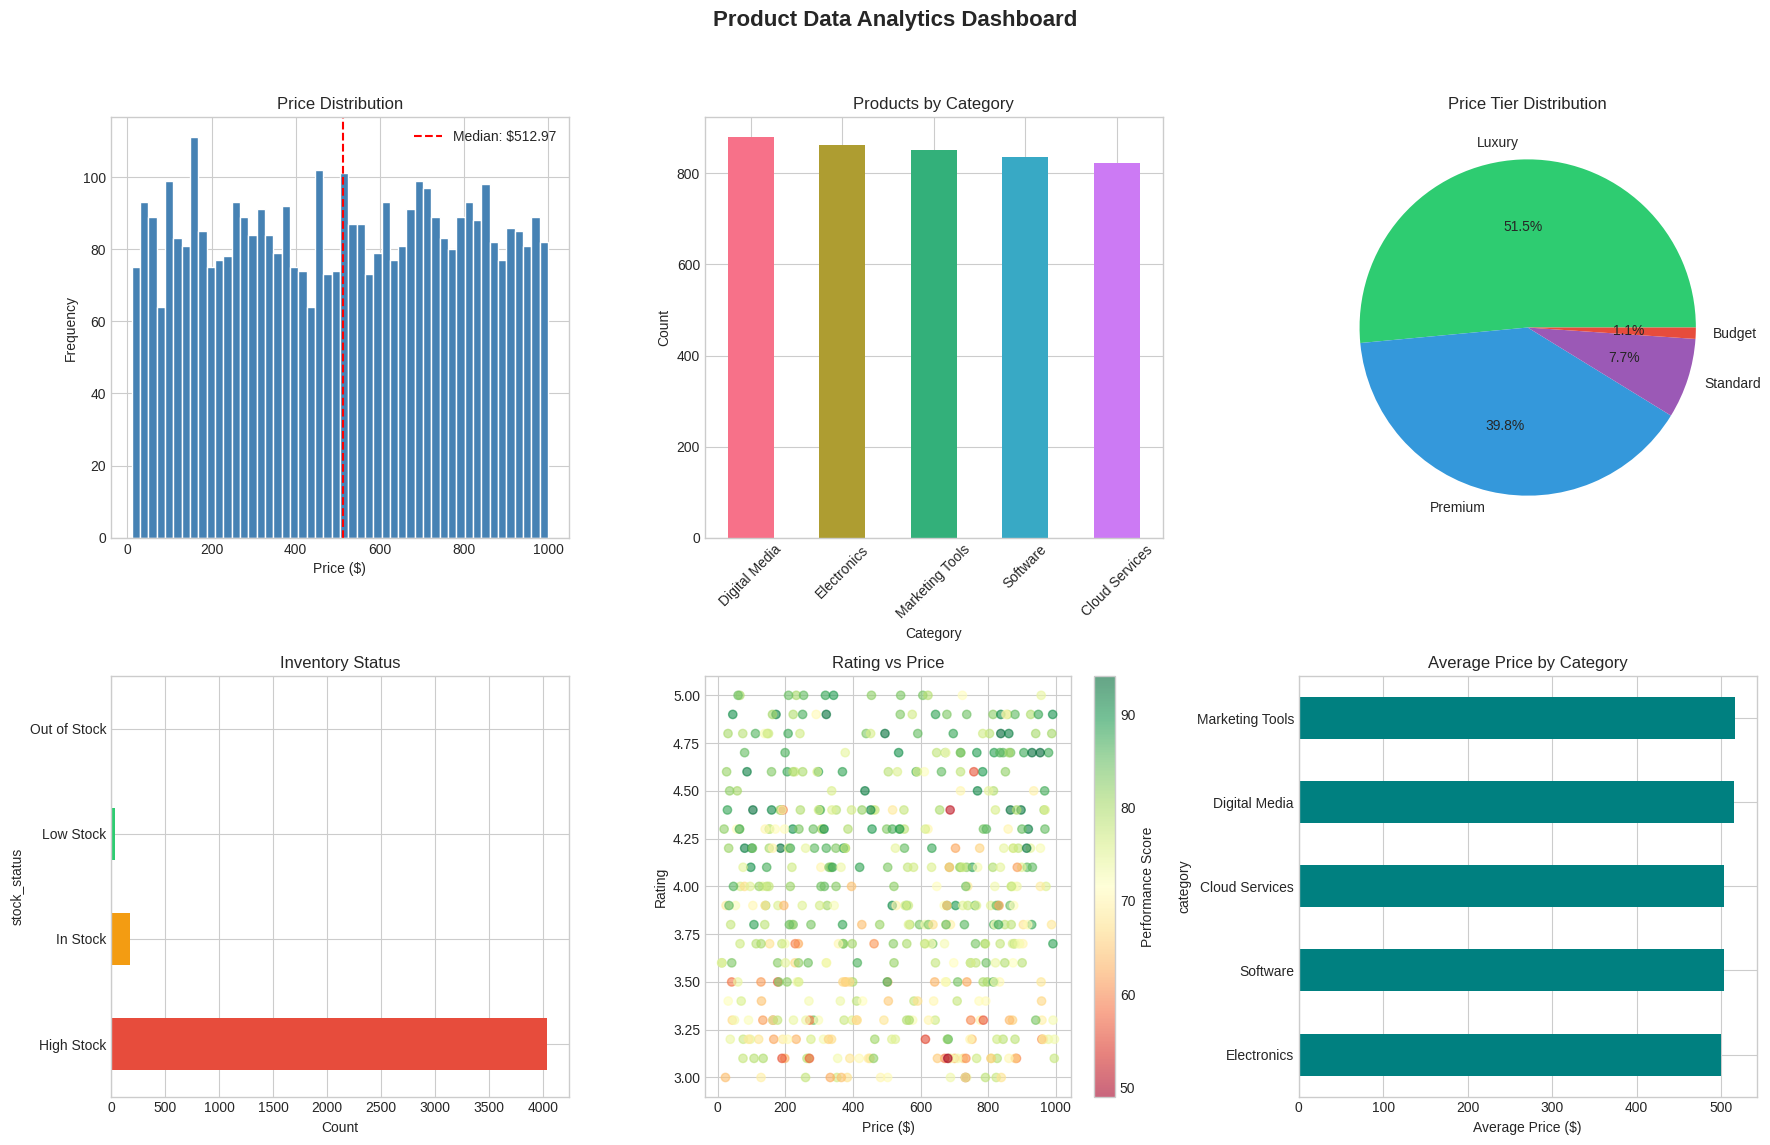


📊 Dashboard saved to: ./extracted_data/analytics_dashboard.png


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Product Data Analytics Dashboard', fontsize=16, fontweight='bold')

# 1. Price Distribution
ax1 = axes[0, 0]
transformed_df['price'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='white')
ax1.set_title('Price Distribution')
ax1.set_xlabel('Price ($)')
ax1.set_ylabel('Frequency')
ax1.axvline(transformed_df['price'].median(), color='red', linestyle='--', label=f'Median: ${transformed_df["price"].median():.2f}')
ax1.legend()

# 2. Products by Category
ax2 = axes[0, 1]
category_counts = transformed_df['category'].value_counts()
category_counts.plot(kind='bar', ax=ax2, color=sns.color_palette('husl', len(category_counts)))
ax2.set_title('Products by Category')
ax2.set_xlabel('Category')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# 3. Price Tier Distribution
ax3 = axes[0, 2]
if 'price_tier' in transformed_df.columns:
    tier_counts = transformed_df['price_tier'].value_counts()
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
    tier_counts.plot(kind='pie', ax=ax3, autopct='%1.1f%%', colors=colors)
    ax3.set_title('Price Tier Distribution')
    ax3.set_ylabel('')

# 4. Stock Status
ax4 = axes[1, 0]
if 'stock_status' in transformed_df.columns:
    stock_counts = transformed_df['stock_status'].value_counts()
    stock_counts.plot(kind='barh', ax=ax4, color=['#e74c3c', '#f39c12', '#2ecc71', '#3498db'])
    ax4.set_title('Inventory Status')
    ax4.set_xlabel('Count')

# 5. Rating vs Price
ax5 = axes[1, 1]
if 'rating' in transformed_df.columns:
    sample_df = transformed_df.dropna(subset=['rating']).sample(min(500, len(transformed_df)))
    scatter = ax5.scatter(sample_df['price'], sample_df['rating'],
                          c=sample_df['performance_score'] if 'performance_score' in sample_df.columns else 'steelblue',
                          alpha=0.6, cmap='RdYlGn')
    ax5.set_title('Rating vs Price')
    ax5.set_xlabel('Price ($)')
    ax5.set_ylabel('Rating')
    if 'performance_score' in sample_df.columns:
        plt.colorbar(scatter, ax=ax5, label='Performance Score')

# 6. Average Price by Category
ax6 = axes[1, 2]
avg_price_by_category = transformed_df.groupby('category')['price'].mean().sort_values(ascending=True)
avg_price_by_category.plot(kind='barh', ax=ax6, color='teal')
ax6.set_title('Average Price by Category')
ax6.set_xlabel('Average Price ($)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'{config.output_dir}/analytics_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Dashboard saved to: {config.output_dir}/analytics_dashboard.png")

---
## 13. Pipeline Orchestrator (Production-Ready)

In [14]:
class ProductExtractionOrchestrator:
    """Orchestrate the complete extraction pipeline."""

    def __init__(self, config: ExtractionConfig):
        self.config = config
        self.logger = logging.getLogger('Orchestrator')
        self.run_id = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.metrics = {}

    def run_pipeline(self, extractors: List[BaseExtractor]) -> Dict:
        """Execute full extraction pipeline."""
        self.logger.info(f"Starting pipeline run: {self.run_id}")
        start_time = time.time()

        all_products = []
        extraction_results = []

        # Step 1: Extract from all sources
        self.logger.info("Step 1: Extracting data from sources...")
        for extractor in extractors:
            try:
                products = extractor.extract()
                all_products.extend(products)
                extraction_results.append({
                    'source': extractor.__class__.__name__,
                    'status': 'success',
                    'count': len(products),
                    'stats': extractor.get_stats()
                })
            except Exception as e:
                self.logger.error(f"Extraction failed for {extractor.__class__.__name__}: {e}")
                extraction_results.append({
                    'source': extractor.__class__.__name__,
                    'status': 'failed',
                    'error': str(e)
                })

        # Step 2: Validate data quality
        self.logger.info("Step 2: Validating data quality...")
        validator = DataQualityValidator()
        quality_report = validator.validate(all_products)

        # Step 3: Transform data
        self.logger.info("Step 3: Transforming data...")
        transformer = DataTransformationPipeline()
        transformed_df = transformer.run(all_products)

        # Step 4: Export data
        self.logger.info("Step 4: Exporting data...")
        exporter = DataExporter(self.config.output_dir)
        export_columns = [col for col in transformed_df.columns
                          if col not in ['attributes', 'images', 'updated_at_dt']]
        export_df = transformed_df[export_columns].copy()
        export_paths = exporter.export_all(export_df, f'products_{self.run_id}')

        # Compile final metrics
        elapsed_time = time.time() - start_time

        self.metrics = {
            'run_id': self.run_id,
            'status': 'completed',
            'total_products': len(all_products),
            'total_sources': len(extractors),
            'quality_score': quality_report['overall_quality_score'],
            'elapsed_time_seconds': round(elapsed_time, 2),
            'extraction_results': extraction_results,
            'quality_report': quality_report,
            'export_paths': export_paths,
            'transformations': transformer.transformations_applied
        }

        # Save pipeline report
        report_path = os.path.join(self.config.output_dir, f'pipeline_report_{self.run_id}.json')
        with open(report_path, 'w') as f:
            json.dump(self.metrics, f, indent=2, default=str)

        self.logger.info(f"Pipeline completed in {elapsed_time:.2f}s")
        return self.metrics

# Run full pipeline
print("\n" + "="*60)
print("🚀 RUNNING COMPLETE EXTRACTION PIPELINE")
print("="*60)

orchestrator = ProductExtractionOrchestrator(config)
pipeline_results = orchestrator.run_pipeline([sql_extractor])

print("\n" + "="*60)
print("📋 PIPELINE EXECUTION SUMMARY")
print("="*60)
print(f"   Run ID: {pipeline_results['run_id']}")
print(f"   Status: {pipeline_results['status']}")
print(f"   Total Products: {pipeline_results['total_products']:,}")
print(f"   Quality Score: {pipeline_results['quality_score']:.1f}%")
print(f"   Execution Time: {pipeline_results['elapsed_time_seconds']}s")
print(f"\n   Export Files:")
for fmt, path in pipeline_results['export_paths'].items():
    print(f"      - {fmt.upper()}: {path}")


🚀 RUNNING COMPLETE EXTRACTION PIPELINE

📋 PIPELINE EXECUTION SUMMARY
   Run ID: 20260121_023758
   Status: completed
   Total Products: 4,251
   Quality Score: 100.0%
   Execution Time: 6.33s

   Export Files:
      - CSV: ./extracted_data/products_20260121_023758.csv
      - JSON: ./extracted_data/products_20260121_023758.json
      - PARQUET: ./extracted_data/products_20260121_023758.parquet
      - EXCEL: ./extracted_data/products_20260121_023758.xlsx
      - SQL: ./extracted_data/exports.db


---
## 14. Summary & Key Takeaways

### Architecture Highlights

This pipeline demonstrates production-ready data extraction capabilities:

1. **Modular Design**: Abstract base classes enable easy extension to new data sources
2. **Robust Error Handling**: Retry logic with exponential backoff
3. **Data Quality**: Comprehensive validation with automated quality scoring
4. **Performance**: Async batch processing, chunked reads, parallel execution
5. **Flexibility**: Multi-format export (CSV, JSON, Parquet, Excel, SQL)
6. **Observability**: Detailed logging, metrics, and pipeline reports

### Relevance to Adobe Data Science

This pipeline architecture is directly applicable to:

- **Adobe Commerce**: Catalog data extraction and synchronization
- **Adobe Experience Platform**: Data ingestion and transformation
- **Adobe Analytics**: Product performance data pipelines
- **Adobe Target**: A/B testing data extraction
- **Adobe Real-Time CDP**: Customer data unification

### Technical Skills Demonstrated

- Object-Oriented Python with type hints
- Async/concurrent programming
- SQL and database operations
- REST API integration
- Data validation and quality assurance
- ETL pipeline orchestration
- Data visualization and analytics

In [16]:
# Final cleanup and file listing
print("\n📁 Generated Files:")
for file in os.listdir(config.output_dir):
    filepath = os.path.join(config.output_dir, file)
    size = os.path.getsize(filepath) / 1024
    print(f"   {file} ({size:.1f} KB)")

print("\n✅ Pipeline execution complete!")


📁 Generated Files:
   products_20260121_023758.parquet (1060.3 KB)
   analytics_dashboard.png (380.1 KB)
   products_20260121_023758.csv (2285.1 KB)
   products_20260121_023758.json (5252.4 KB)
   product_catalog.csv (2285.1 KB)
   product_catalog.json (5252.4 KB)
   product_catalog.parquet (1059.0 KB)
   pipeline_report_20260121_023758.json (1.7 KB)
   product_catalog.xlsx (1313.1 KB)
   exports.db (4820.0 KB)
   products_20260121_023758.xlsx (1313.5 KB)

✅ Pipeline execution complete!
